In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor
import plot_configs

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'
prompt_path = './prompts/three_hop_prompts.csv'

# Load model and extractor

In [3]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )
activation_extractor.overwrite_chat_template()

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Select Prompt

In [175]:
prompt_df = pd.read_csv(prompt_path)
idx = 13
concept = 'person'
person = prompt_df.iloc[idx]['Person']
state = prompt_df.iloc[idx]['State']
reasoning_question = prompt_df.iloc[idx]['Prompt']
print(person)
print(state)
print(reasoning_question)

Louisa May Alcott
Pennsylvania
What is the capital of the state where the author of Little Women was born?


# Get random words to make null baseline

In [176]:
import nltk
import random
from nltk.corpus import brown

nltk.download('brown')

def get_frequent_words(count=50):
    # Get all words from the Brown corpus
    word_list = brown.words()
    
    # Filter shorter, simpler words
    filtered_words = [word.lower() for word in word_list if len(word) <= 8 and word.isalpha()]
    
    # Get unique words and sample
    unique_words = list(set(filtered_words))
    random.seed(0)
    sampled_words = random.sample(unique_words, count)
    random.seed()
    return sampled_words

randomly_sampled_words = get_frequent_words()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [177]:
print(randomly_sampled_words)

['bragging', 'babbitt', 'tilting', 'turne', 'field', 'bombs', 'builder', 'rouge', 'jewish', 'grevyles', 'budge', 'attain', 'waning', 'chapel', 'deputy', 'shot', 'deux', 'scatter', 'hanging', 'agenda', 'arched', 'muscovy', 'tuition', 'medicale', 'parsons', 'make', 'awards', 'madame', 'topic', 'prosser', 'railhead', 'peaky', 'nudes', 'borden', 'whites', 'risks', 'illusive', 'motley', 'pampered', 'riven', 'tidal', 'howda', 'offenses', 'wholly', 'slope', 'screvane', 'unfairly', 'brisbane', 'grossman', 'goodby']


# Make Probes

In [178]:
def get_probe(activation_extractor, prompt=None, role="assistant"):
    # List of prompts to process
    if prompt is None:
        prompts = randomly_sampled_words
    else:
        prompts = [prompt]

    # Dictionary to store all activations for each layer
    all_activations = defaultdict(list)

    # Process each prompt
    for prompt in prompts:
        if role == 'assistant':
            prompt = "<think>\n</think>\n\n" + prompt
        print(f"Processing prompt: '{prompt}'")

        # Format the prompt
        formatted = activation_extractor.tokenizer.apply_chat_template(
            [{'role': role, 'content': prompt}],
            tokenize=False,
        )
        formatted  = formatted.split(activation_extractor.tokenizer.eos_token)[0]

        # Get activations
        print(formatted)
        results = activation_extractor.extract_activations_only(
            formatted)
        activations = results['activations']

        # Store the last token activations for each layer
        for key in activations.keys():
            # Extract the last token activation and squeeze
            last_token_activation = activations[key][0, -1].squeeze()
            all_activations[key].append(last_token_activation)

    # Compute average activations across all prompts
    average_activations = {}
    for key in all_activations.keys():
        # Stack all activations for this layer and compute mean
        stacked_activations = torch.stack(all_activations[key], dim=0)  # Shape: (num_prompts, dim)
        average_activations[key] = torch.mean(stacked_activations, dim=0)  # Shape: (dim,)
    return average_activations

In [179]:
if concept == 'person':
    chat_probes = get_probe(activation_extractor, person)
elif concept == 'state':
    chat_probes = get_probe(activation_extractor, state)
else:
    raise ValueError("Concept must be either 'person' or 'state'.")

Processing prompt: '<think>
</think>

Louisa May Alcott'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

Louisa May Alcott


In [180]:
null_probes = get_probe(activation_extractor)

Processing prompt: '<think>
</think>

bragging'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

bragging
Processing prompt: '<think>
</think>

babbitt'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

babbitt
Processing prompt: '<think>
</think>

tilting'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

tilting
Processing prompt: '<think>
</think>

turne'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

turne
Processing prompt: '<think>
</think>

field'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

field
Processing prompt: '<think>
</think>

bombs'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

bombs
Processing prompt: '<think>
</think>

builder'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

builder
Processing prompt: '<think>
</think>

rouge'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

rouge
Processing prompt: '<think>
</think>

jewish'
<｜begin▁of▁sentence｜><｜Assistant｜><think>
</think>

jewish
Processing prompt: '<think>
</think>

grevyles'
<｜beg

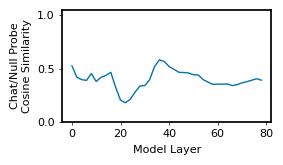

In [181]:
probe_similarity = []
probe_layer = []
for k in chat_probes.keys():
    layer = k.split('_')[1]  # Extract layer number from key
    _chat_probe = chat_probes[k]
    _null_probe = null_probes[k]
    _chat_probe = F.normalize(_chat_probe, dim=0)
    _null_probe = F.normalize(_null_probe, dim=0)
    probe_similarity.append(torch.dot(_chat_probe, _null_probe).item())
    probe_layer.append(int(layer))
plt.figure(figsize=(3., 1.75))
plt.plot(probe_layer, probe_similarity)
plt.ylim(0, 1.05)
plt.xlabel("Model Layer", fontsize=8)
plt.ylabel("Chat/Null Probe\nCosine Similarity", fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [182]:
baseline_subtracted_probes = {}
for k in chat_probes.keys():
    # Subtract the null probe activations from the chat probe activations
    baseline_subtracted_probes[k] = chat_probes[k] - null_probes[k]

# Get model activations to reasoning question

In [183]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)
generation_results = activation_extractor.generate_with_activations(
    formatted,
    do_sample=False,
    max_new_tokens=1500,
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [184]:
rot13_alpha(generation_results['response'].split('</think>')[0].strip('\n'))

"Okay, so I need to figure out the capital of the state where the author of Little Women was born. Let me break this down step by step. First, I should identify who the author of Little Women is. I remember that Little Women is a classic novel, and I think the author was a woman. Hmm, wasn't it Juliaard? Yeah, Julianed Dill. Wait, no, that doesn't sound right. Maybe it's Julianed something else. Oh, right, Julianed Dill is actually the author of some other books, like The Scarecrow and the Timebrew. Wait, no, that's Julianed Dill, but I think she wrote for children. Wait, no, Little Women is by Julianed Dill? Or is it someone else? Wait, I'm getting confused. Let me think again. I believe the author of Little Women is Julianed Dill, but I'm not entirely sure. Wait, no, I think it's Julianed Dill. Or maybe it's Julianed something else. Wait, no, I think it's Julianed Dill. But I'm not 100% certain. Maybe I should double-check that. Alternatively, perhaps it's Julianed Dill. Yeah, I thin

# Probe model activations for maximally-activating subset of transcript

In [185]:
end_think_idx = np.argwhere(np.array(generation_results['response_tokens']) == "</think>")
if end_think_idx.size != 0:
    end_think_idx = end_think_idx.item()
else:
    end_think_idx = len(generation_results['response_tokens'])

In [186]:
output_len = len(generation_results['response_tokens'])
translated_tokens = []
original_tokens = []
for i, t in enumerate(generation_results['response_tokens']):
    _t = rot13_alpha(t) if i < end_think_idx else t
    original_tokens.append(t)
    translated_tokens.append(_t)
formatted_person = person.lower().replace(" ", "_")

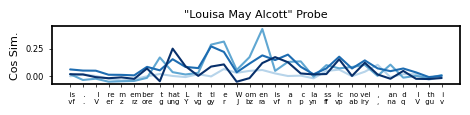

In [187]:
import matplotlib as mpl

key_of_interest = "layer_20"
model_response = generation_results['token_activations'][key_of_interest].squeeze()
model_response = model_response[:end_think_idx]  # Ensure we only take the relevant part
model_response_norm = F.normalize(model_response, p=2, dim=-1)

baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[key_of_interest], p=2, dim=-1)
probe_sim = model_response_norm @ baseline_subtracted_probe
probe_sim = probe_sim.to(torch.float32).numpy()

# Find the index with the highest similarity
max_index = np.argmax(probe_sim)
window_len = 15

# Define the range for plotting
start_idx = max(0, max_index - window_len)
end_idx = min(output_len, max_index + window_len)
layers_to_plot = ["layer_10", "layer_20", "layer_40", "layer_60"]
# Adjust the color range to start at a higher value (e.g., 0.3)
cmap = plt.cm.Blues
color_start = 0.3  # Start of the color range
color_end = 1.0    # End of the color range
colors = [cmap(
    color_start + i * (color_end - color_start) / (len(layers_to_plot) - 1)
    ) for i in range(len(layers_to_plot))]
probe_sims = {}

for layer in layers_to_plot:
    model_response = generation_results['token_activations'][layer].squeeze()
    model_response_norm = F.normalize(model_response, p=2, dim=-1)

    baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[layer], p=2, dim=-1)
    probe_sim = model_response_norm[-output_len:] @ baseline_subtracted_probe
    probe_sims[layer] = probe_sim.to(torch.float32).numpy()

# Plot the similarities for the specified range
plt.figure(figsize=(4.75, 1.25))
for layer_idx, layer in enumerate(layers_to_plot):
    plt.plot(
        np.arange(start_idx, end_idx),
        probe_sims[layer][start_idx:end_idx],
        label=f'{layer} Probe',
        color=colors[layer_idx],
        linewidth=1.5
    )
xticklabels = [
    f" {translated_tokens[i]}\n{original_tokens[i]}"
    for i in range(start_idx, end_idx)
]
title = f'\"{person}\" Probe' if concept=='person' else f'\"{state}\" Probe'
plt.title(title, fontsize=8)
plt.ylabel('Cos Sim.', fontsize=8)
plt.xticks(np.arange(start_idx, end_idx), xticklabels, fontsize=5)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig(f"figures/2a_P{idx}_{concept}.png", dpi=300, transparent=True)
plt.savefig(f"pdfs/2a_P{idx}_{concept}.pdf", dpi=300, transparent=True)
plt.show()


# Probe model activations over the entire transcript

In [ ]:
output_len = len(generation_results['response_tokens'])
out_tokens = []
for i, t in enumerate(generation_results['response_tokens']):
    _t = rot13_alpha(t) if i < end_think_idx else t
    out_tokens.append(_t)
formatted_person = person.lower().replace(" ", "_")
with PdfPages(f"pdfs/baseline_subtracted_probe_{formatted_person}.pdf") as pdf:
    for key in baseline_subtracted_probes.keys():
        model_response = generation_results['token_activations'][key].squeeze()
        model_response_norm = F.normalize(model_response, p=2, dim=-1)

        baseline_subtracted_probe = F.normalize(baseline_subtracted_probes[key], p=2, dim=-1)
        probe_sim = model_response_norm[-output_len:] @ baseline_subtracted_probe
        probe_sim = probe_sim.to(torch.float32).numpy()

        plt.figure(figsize=(60, 1.))
        plt.plot(probe_sim, label='Chat Probe', color='blue')
        plt.title(key, fontsize=8)
        plt.ylabel('Cos Sim.', fontsize=8)
        plt.xticks(np.arange(output_len), out_tokens, fontsize=6, rotation=45)
        plt.ylim(0, 1)
        plt.legend()
        
        # Save the current figure to the PDF instead of showing it
        pdf.savefig(bbox_inches='tight')
        plt.close() 

/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/2880804757.py:25: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  pdf.savefig(bbox_inches='tight')
/tmp/ipykernel_2853/28808047